<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Session 7: Explainability and Interpretability</span></div>

by BYJ Cirio

<div class="alert alert-danger alert-info">
     In this notebook you will learn different explaibility and interpretability techniques. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>SHAP</li>
        <li>LIME</li>
        <li><i>Exercise: Implement and explore other SHAP techniques</i></li>
    </ol>
</div>

In [1]:
# general libraries
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

# modelling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

# evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, make_scorer

# interpretability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

In [3]:
df = pd.read_csv('data/transactions_clean_onehot.csv', nrows=100000)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.head()

,is_fraud,diff_datetime_hrs,prev_fraud,amt,city_pop,age,dist_to_merch_in_kms,category_entertainment,category_food_dining,category_gas_transport,...,city_San Pedro,city_Santa Rosa,city_Sorsogon,city_Surigao,city_Tacloban,city_Taguig City,city_Tagum,city_Tandag,city_Tarlac City,city_Valenzuela
0,0,NaN,0.0,115.58,574089,83,66.720087,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,7.0,0.0,4.35,574089,83,89.750504,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,0.0,4.65,574089,83,31.625560,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,13.0,0.0,32.87,574089,83,112.130879,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.0,192.43,574089,83,101.931179,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['diff_datetime_hrs'] = df['diff_datetime_hrs'].fillna(0)
df

,is_fraud,diff_datetime_hrs,prev_fraud,amt,city_pop,age,dist_to_merch_in_kms,category_entertainment,category_food_dining,category_gas_transport,...,city_San Pedro,city_Santa Rosa,city_Sorsogon,city_Surigao,city_Tacloban,city_Taguig City,city_Tagum,city_Tandag,city_Tarlac City,city_Valenzuela
0,0,0.0,0.0,115.58,574089,83,66.720087,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,7.0,0.0,4.35,574089,83,89.750504,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,0.0,4.65,574089,83,31.625560,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,13.0,0.0,32.87,574089,83,112.130879,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.0,192.43,574089,83,101.931179,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89645,0,28.0,0.0,46.64,345366,78,86.553592,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89646,0,4.0,0.0,9.69,345366,78,58.165162,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89647,0,53.0,0.0,109.12,345366,78,117.585308,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89648,0,25.0,0.0,79.57,345366,78,92.190943,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Evaluating Model Performance </span></div>

In [6]:
model =  GradientBoostingClassifier(random_state=42)
model = model.fit(X_trainval, y_trainval)

In [7]:
y_preds = model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)
print(f"Holdout set score: {holdout_score:.2f}")

Holdout set score: 0.98


<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">SHAP </span></div>

Define the `shap` explainer. Use the appropriate explainer based on our trained model.

In [8]:
explainer = shap.TreeExplainer(model, feature_names=X_holdout.columns)

Compute for the shapley values of each features using the `shap_value()` method of the `explainer` object.

In [9]:
shap_values = explainer.shap_values(X_holdout)

Now, let's look at how the model makes predictions. We observe that for transaction `74511` in the hold-out test set, our model predicts it to be fraudulent.

In [12]:
model.predict(X_holdout.loc[[89645]])

array([0], dtype=int64)

In [13]:
# find the location
loc_df = X_holdout.reset_index()
loc_df[loc_df['index'] == 89645]

,index,diff_datetime_hrs,prev_fraud,amt,city_pop,age,dist_to_merch_in_kms,category_entertainment,category_food_dining,category_gas_transport,...,city_San Pedro,city_Santa Rosa,city_Sorsogon,city_Surigao,city_Tacloban,city_Taguig City,city_Tagum,city_Tandag,city_Tarlac City,city_Valenzuela
21169,89645,28.0,0.0,46.64,345366,78,86.553592,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Force Plot

***Code Specifics***

We can generate force plot using ``force_plot()`` method. Below are some of the parameters you may use for the ``force_plot()``.

```
Parameters
----------
base_value : float
    This is the reference value that the feature contributions start from. 
    For SHAP values it should be the value of explainer.expected_value.

shap_values : numpy.array
    Matrix of SHAP values (# features) or (# samples x # features). 
    If this is a 1D array then a single force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.

features : numpy.array
    Matrix of feature values (# features) or (# samples x # features). 
    This provides the values of all the features, and should be the same shape as the shap_values argument.

matplotlib : bool
    Whether to use the default Javascript output, or the (less developed) matplotlib output. 
    Using matplotlib can be helpful in scenarios where rendering Javascript/HTML is inconvenient. 
```

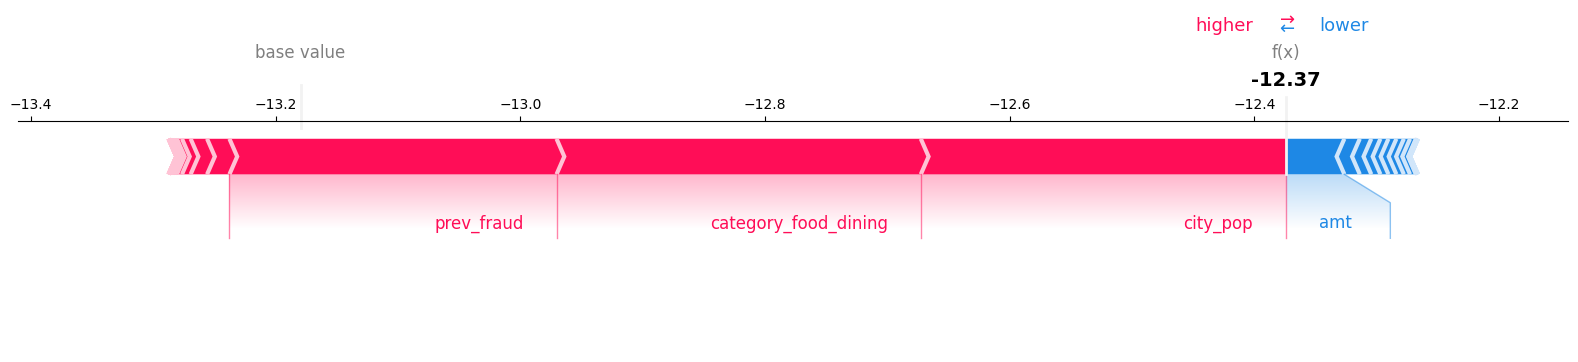

In [14]:
shap.force_plot(explainer.expected_value, 
                shap_values[275], X_holdout.columns, matplotlib=True)

In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance.

### Feature Importance

***Code Specifics***

We can generate summary plot using `summary_plot()` method. Below are list of important parameters of `summary_plot()` method.

```
Parameters
----------
shap_values : numpy.array
    For single output explanations this is a matrix of SHAP values (# samples x # features).
    For multi-output explanations this is a list of such matrices of SHAP values.
​
features : numpy.array or pandas.DataFrame or list
    Matrix of feature values (# samples x # features) or a feature_names list as shorthand
​
plot_type : "dot" (default for single output), "bar" (default for multi-output), "violin",
    or "compact_dot".
    What type of summary plot to produce. Note that "compact_dot" is only used for
    SHAP interaction values.
```
​
Next, we sort the features by decreasing importance and plot them. The following figure shows the SHAP feature importance for the random forest trained before for predicting cervical cancer.

In [15]:
shap_vals = shap_values[0]

feature_importance = pd.DataFrame(list(zip(X.columns, shap_vals)),
                                  columns=['column_value', 'shap_vals'])

feature_importance.sort_values(by=['shap_vals'], 
                               ascending=False, 
                               inplace=True)

feature_importance

,column_value,shap_vals
3,city_pop,0.298482
7,category_food_dining,0.297820
1,prev_fraud,0.267437
151,merchant_SM Retail Inc,0.018269
28,prev_category_shopping_net,0.013447
...,...,...
5,dist_to_merch_in_kms,-0.006535
9,category_grocery_pos,-0.007467
74,merchant_FiveStar,-0.009392
182,merchant_Typo,-0.012559


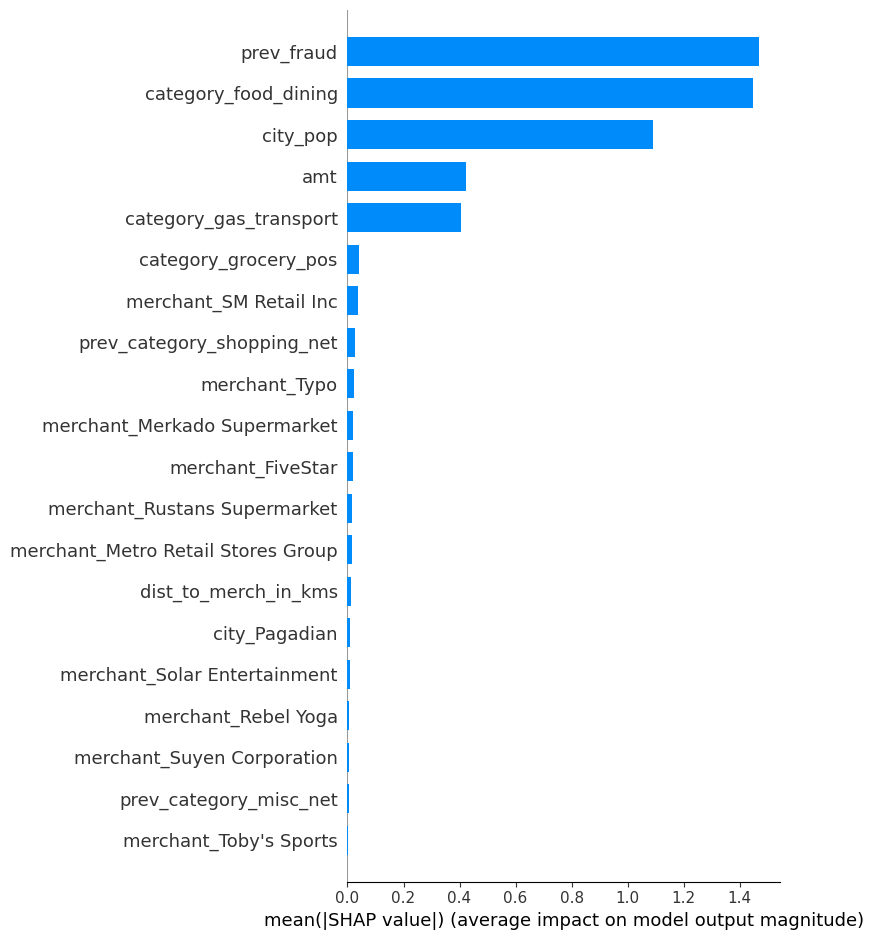

In [16]:
shap.summary_plot(shap_values=shap_values, 
                  features=X_holdout.columns, 
                  plot_type="bar")

### Beeswarm Plot

***Code Specifics***

We can generate summary plot using ``summary_plot()`` method. Below are list of important parameters of ``summary_plot()``.

```
Parameters
----------
shap_values : numpy.array
    For single output explanations this is a matrix of SHAP values (# samples x # features).
    For multi-output explanations this is a list of such matrices of SHAP values.

features : numpy.array or pandas.DataFrame or list
    Matrix of feature values (# samples x # features) or a feature_names list as shorthand

plot_type : "dot" (default for single output), "bar" (default for multi-output), "violin",
    or "compact_dot".
    What type of summary plot to produce. Note that "compact_dot" is only used for
    SHAP interaction values.
```

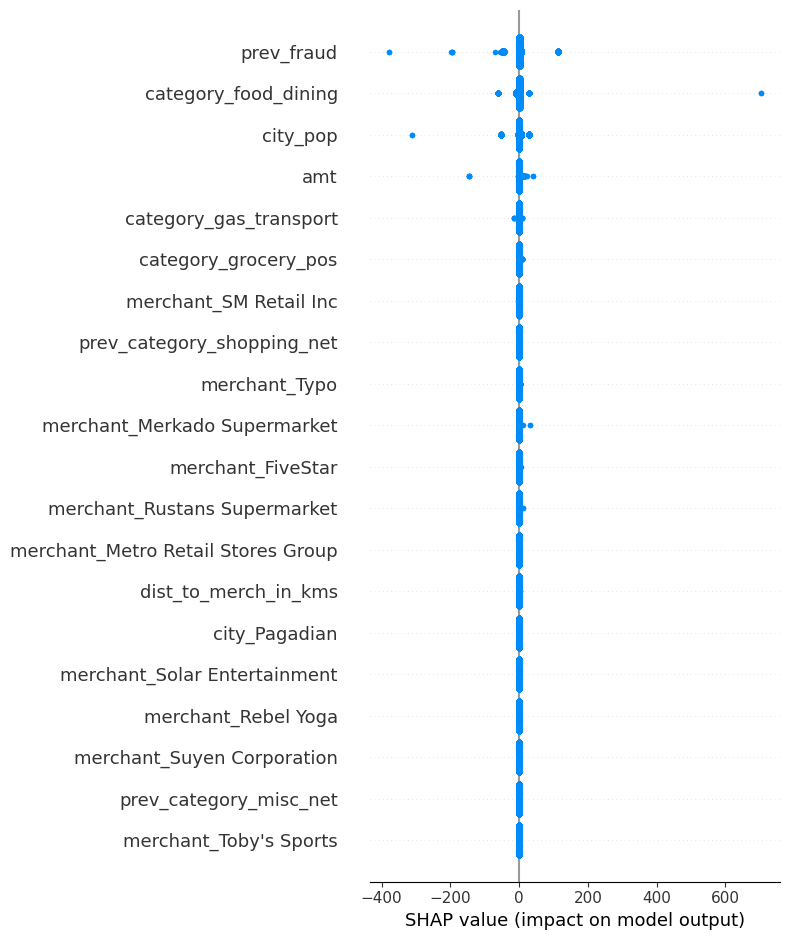

In [17]:
shap.summary_plot(shap_values = shap_values, 
                  features = X_holdout.columns)

### Dependence Plot

**Code Specifics**

We can generate summary plot using ``dependence_plot()`` method. Below are list of important parameters of ``dependence_plot()``.

```
Parameters
----------
ind : int or string
    If this is an int it is the index of the feature to plot. If this is a string it is
    either the name of the feature to plot, or it can have the form "rank(int)" to specify
    the feature with that rank (ordered by mean absolute SHAP value over all the samples).

shap_values : numpy.array
    Matrix of SHAP values (# samples x # features).

features : numpy.array or pandas.DataFrame
    Matrix of feature values (# samples x # features).

interaction_index : "auto", None, int, or string
    The index of the feature used to color the plot. The name of a feature can also be passed
    as a string. If "auto" then shap.common.approximate_interactions is used to pick what
    seems to be the strongest interaction (note that to find to true stongest interaction you
    need to compute the SHAP interaction values).
    
```

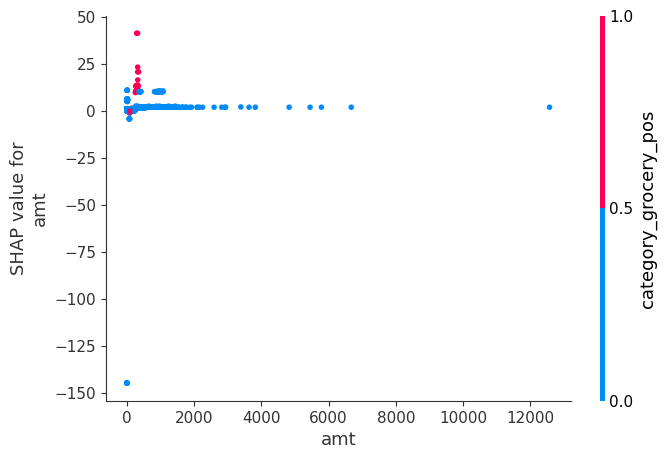

In [18]:
shap.dependence_plot(ind='amt', 
                     shap_values = shap_values, 
                     features = X_holdout)

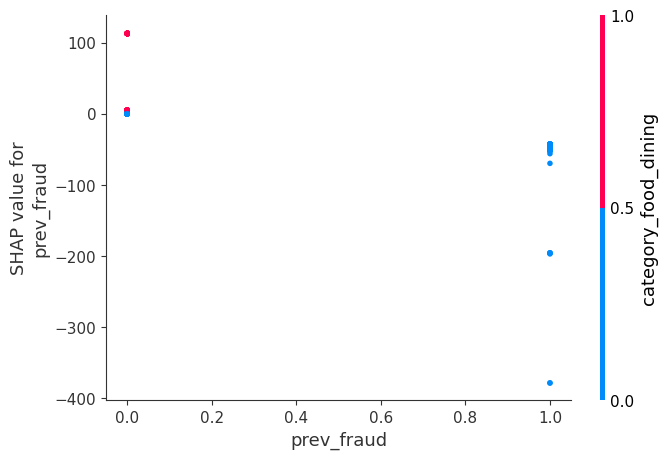

In [24]:
shap.dependence_plot(ind='prev_fraud', 
                     shap_values = shap_values, 
                     features = X_holdout)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">LIME </span></div>

In this section, we will see how [Lime](https://lime-ml.readthedocs.io/en/latest/lime.html) is used for interpreting models.

In [19]:
# ! pip install lime

In [20]:
X_trainval.values

array([[ 5.  ,  0.  ,  3.33, ...,  0.  ,  0.  ,  0.  ],
       [13.  ,  0.  ,  7.97, ...,  0.  ,  0.  ,  0.  ],
       [14.  ,  0.  , 98.07, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [39.  ,  0.  ,  4.95, ...,  0.  ,  0.  ,  0.  ],
       [10.  ,  0.  ,  3.53, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  , 73.95, ...,  0.  ,  0.  ,  0.  ]])

In [21]:
explainer = LimeTabularExplainer(X_trainval.values, mode="classification",
                                 class_names=[0, 1],
                                 feature_names=X_trainval.columns,
                                 discretize_continuous=True
                                 )

Again checking for transaction `275`.

In [22]:
X_holdout.iloc[275]

diff_datetime_hrs         1.00
prev_fraud                0.00
amt                      84.95
city_pop             112788.00
age                      95.00
                       ...    
city_Taguig City          0.00
city_Tagum                0.00
city_Tandag               0.00
city_Tarlac City          0.00
city_Valenzuela           0.00
Name: 20767, Length: 253, dtype: float64

In [23]:
i = 275
exp = explainer.explain_instance(
    X_holdout.iloc[275], 
    model.predict_proba, 
    num_features=2, 
    top_labels=1)

exp.show_in_notebook()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Exercise </span></div>

1. Check for other transactions and interpret the results
2. Implement other SHAP plots

<div><span style="background-color: pink; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: black; font-size: 18px; font-weight: bold">Supplementary</span></div>

Below is a list of other available charts with SHAP:

1. **decision_plot** - It shows the path of how the model reached a particular decision based on shap values of individual features. The individual plotted line represents one sample of data and how it reached a particular prediction.
2. **multioutput_decision_plot** - Its decision plot for multi output models.
3. **image_plot** - It plots shape values for images.
4. **monitoring_plot** - It helps in monitoring the behavior of the model over time. It monitors the loss of model overtime.
5. **embedding_plot** - It projects shap values using PCA for 2D visualization.
6. **partial_dependence_plot** - It shows basic partial dependence plot for a feature.
7. **bar_plot** - It shows a bar plot of shap values impact on the prediction of a particular sample.
8. **waterfall_plot** - It shows a waterfall plot explaining a particular prediction of the model based on shap values. It kind of shows the path of how shap values were added to the base value to come to a particular prediction.
9. **text_plot** - It plots an explanation of text samples coloring text based on their shap values.